<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring<br>

---

[//]: ([![mj](mj.png)](https://www.imdb.com/title/tt0117705/))

<h1 style="text-align:center"> 1. Testing the pseudo random number generator </h1>


## exercise 1.1a (uniform distribution sampling)

For a random variable $r$ uniformly distributed in $[0,1]$, the average value and variance have known values:
    
$$ \langle r \rangle = \int_0^1 r dr = \frac{1}{2} \;,\quad \quad \sigma^2 = \int_0^1 \left(r-\frac{1}{2}\right)^2 dr = \frac{1}{12}$$

<p class="assignement"> Generate a long sample (e.g. of $M\geq10^5$ elements) of pseudo-random numbers uniformly distributed between $0$ and $1$ using the generator, then divide the data into $N$ blocks and plot the estimation of $\langle r \rangle$ and $\langle\left(r-\frac{1}{2}\right)^2\rangle$, together with their uncertainties (the standard deviation of the mean), as functions of the number of blocks considered.</p>    

### my solution
    
I generated $10^5$ random numbers uniformly distributed in $[0,1)$ using C++, formally dividing them in $100$ blocks, and calculated the *progressive* average value and variance at each block. 
For efficiency's sake I never stored more than one random number at the time, and at the end of each block I wrote the progressive average and relative uncertainty to the file "average.dat" for the average value and to "variance.dat" for the variance. 

Eevery line of the files contains three values: the number of throws considered, the estimate and its uncertainty up to that point, e.g. if the total number of throws is $10^5$ and the number of blocks is $100$, then the first estimate corresponds to the first $10^5/100 = 1000$ throws, the second to the first $2000$, and so on.

The file is then ready to be loaded and plotted using one's favourite interface, in this notebook 
I will use matplotlib.

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_01/"              # where to look for the data
HTML(custom_css())                          # custom notebook appearance (do not suppress output)

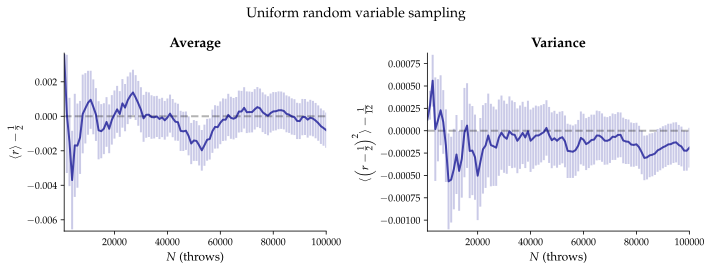

In [2]:
files = [results_directory + "average.dat", results_directory + "variance.dat"]
suptitle = "Uniform random variable sampling"
titles = ["Average", "Variance"]
xlabel = "$N$ (throws)"
ylabels = ["$\langle r\\rangle - \\frac{1}{2}$", "$\langle \left(r-\\frac{1}{2}\\right)^2\\rangle - \\frac{1}{12}$"]
exp_ys = [0.5, 1./12.]

double_estimation(files, suptitle, titles, xlabel, ylabels, exp_ys)

## exercise 1.1b ($\chi^2$ statistic test)

Pearson's cumulative test statistic $\chi^2$ is a measure of the error between observations, $O_i$, and expected values, $E_i$:
    
$$\chi^2 = \sum_{i} \frac{\left( O_i - E_i \right)^2}{E_i}$$
    
<p class="assignement"> Divide $[0,1]$ into $M=100$ identical sub-intervals and implement the $\chi^2$ test using $n=10^4$ pseudo-random numbers, then repeat it for $100$ iterations and plot the results.</p>
    
Be $n$ the total number of throws, and $n_i$ the number of events observed in the $i$-th (equally-spaced) sub-interval in $[0,1]$. If the data is distributed uniformly, then each $n_i$ will follow a binomial distribution with expected value $np =n/M$, and variance $np(1-p)\simeq np$, for $p=1/M=0.01\ll1$. 

In this example the $\chi^2$ statistics of every iteration is given by:
$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$

On average we should expect $(n_i - n/M)^2 \simeq {\rm Var}(n_i) \simeq n/M$ and thus $\chi^2 \simeq M$ (the number of sub-intervals).
A larger value of $\chi^2$ would indicate that the hypothesis ($n_i$ are drawn from a uniform distribution) is rather unlikely.
    
### my solution

Since the $\chi^2$ values of subsequent iterations need not be correlated, a "time-series" like plotting would not give much information other than the order of magnitude of the average $\chi^2$.

What can be insightful in this case is the **spreading around the average**, which is easily shown with an histogram. Moreover, the [$\chi^2$ distribution](https://en.wikipedia.org/wiki/Chi-square_distribution) of $k$ *indipendent standard normal* random variables has a well defined theoretical expression, and since $p\simeq0.01 \ll 1$, the random variables $(n_i-np)/\sqrt{np}$ are *approximately standard normal* (see proof [here](https://en.wikipedia.org/wiki/De_Moivre–Laplace_theorem)), so they should generate a good approximation of the theoretical distribution.

To better see the distribution I decided to repeat the calculation for $\mathbf{10^5}$ **instead of** $\mathbf{10^2}$ iterations. 
    
Down below are plotted the results of the numerical simulation, compared with the theoretical $\chi^2$ distribution with $k=M$ degrees of freedom and a fit of the simulation data with the theoretical distribution, both with the **approximate** variance [$np$] and the **correct** one [$np(1-p)$] (which differ by 1% when $M = 100$).

In [3]:
from scipy.stats import chi2

chi2_data = np.loadtxt(results_directory + "chi2.dat")

def chi2_plot(k, bins=30, fit=True):
    'plot the chi2 density probability obtained with approximate and correct data, both with best th. fit'
    # create figure of the right size for the notebook (containing 2 Axis objects)
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
    # labels
    label_k = f'$(k_{{\\rm th}}={k})$'
    set_labels(ax[0], '(approx.) distribution, with $\sigma^2\simeq np$', '$\\chi^2$', 'fraction')
    set_labels(ax[1], '(correct) distribution, with $\sigma^2 = np(1-p)$', '$\\chi^2$', '')
    
    # x range settings
    index = 2*(int(k/100)-1) # assume k is a multiple of 100 and convert it with the rule (100->0, 200->2, 300->4, 400->6, ...)
    lshift = 60 + 10*index
    rshift = 100 + 10*index
    x = np.linspace(k-lshift, k+rshift, rshift+lshift)
    
    # assume chi2_data has 2n columns, divided in n pairs of columns corresponding to various k, then
    # the approximate values are on the 2k-th column and the correspondend "correct" values are on the
    # (2k+1)-st column 
    chi2_approx = chi2_data[:,index]
    chi2_correct = chi2_data[:,index + 1] 
    
    # plots
    for axis, chi2_sim in zip(ax, [chi2_approx, chi2_correct]):
        # simulated data
        axis.hist(chi2_sim, color='darkgrey', bins=bins, alpha=0.3, rwidth=0.9, density=True, label='simulation')
        if fit:
            # fit theoretical chi2 distribution
            args_fit = chi2.fit(chi2_sim, k, floc=0, fscale=1)
            k_fit = args_fit[0]
            label_kfit = f'$(k_{{\\rm fit}}={k_fit:.2f})$'
            axis.plot(x, chi2.pdf(x, k), ls='--', lw=2, c='darkred', label='theory ' + label_k)
            axis.plot(x, chi2.pdf(x, k_fit), ls='-', lw=4, c='darkblue', label='fit ' + label_kfit, alpha=0.2)
        axis.set_xlim([k-lshift, k+rshift]) # constrain axes
        axis.legend(loc=(.5+index/70,.6));

In [4]:
# interactive plot

from ipywidgets import interactive, SelectionSlider

k_slider = SelectionSlider(options=[ 100 * i for i in range(1,6)], description='k')

#interactive(chi2_plot, bins=[20, 30, 40, 50], k=k_slider, fit=False) # <- uncomment for other values of k

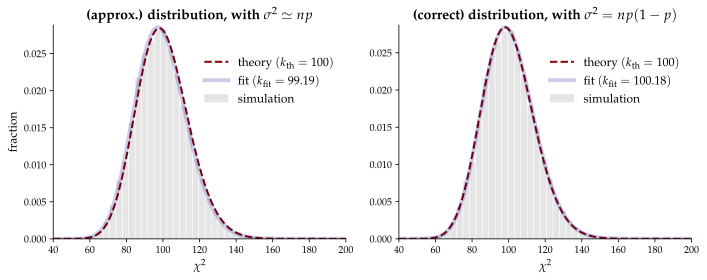

In [5]:
# simple plot

chi2_plot(100)

<p class='remark'>The comparison between the approximate and correct formulae for the variance used in the $\chi^2$ calculation shows that the latter approximates better the expected distribution.
More specifically in this case $p=1/M=0.01$, i.e. the error is exactly of 1 part in 100, which is picked up by the fit parameter $k$.</p>

## exercise 1.2
    
After adding the possibility of sampling pseudo-random numbers from 
    
- a generic <a href="https://en.wikipedia.org/wiki/Exponential_distribution">exponential distribution</a>: $$p(x) = \lambda e^{-\lambda x}\text{  , with }x\in [0,+\infty) \text{ and } \lambda>0$$
    
- a generic <a href="https://en.wikipedia.org/wiki/Cauchy_distribution">Cauchy-Lorentz distribution</a>:
    $$p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}\text{  , with }x\in (-\infty,+\infty)$$

by means of the **method of the inversion of the cumulative distribution**
<p class="assignement"> Generate 3 histograms filled with the results of $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), $x_i$ being a random variable sampled throwing a <i>generalized</i> <b>standard</b> die (uniform in $[0,1]$), an <b>exponential</b> die (using $\lambda=1$) and a <b>Lorentzian</b> die (using $\mu=0$ and $\Gamma=1$).<p>

<p class="remark"> You can try to fit the case $N=100$ with a Gaussian for standard and exponential dice, whereas you should use a Cauchy-Lorentz distribution for the last case.</p>
    
### my solution


In [6]:
# load data

uniform_die = np.loadtxt(results_directory + "uniform_die.dat")
exponential_die = np.loadtxt(results_directory + "exponential_die.dat")[1:,:]
lorentz_die = np.loadtxt(results_directory + "lorentz_die.dat")[1:,:]

sizes = uniform_die[0,:].astype(int) # sample sizes used in the simulations
uniform_die = uniform_die[1:,:]
print(sizes)

# plot settings

from scipy.stats import norm, cauchy

def four_histograms(fig, ax, data, name, bins=20, color='grey'):
    for i in range(4):
        N = sizes[i]
        set_labels(ax[i], title=f'$N = {{{N}}}$', xlabel='outcome')
        ax[i].hist(data[:,i], bins=bins, color=color, alpha=.5, rwidth=0.9, density=True)
    fig.suptitle(f'\\textbf{{ {name.title()} die}} - averages of $N$ throws')
    ax[0].set_ylabel('fraction')
    
text_x, text_y = 0.65, 0.7 # position for some text description in the graphs

[  1   2  10 100]


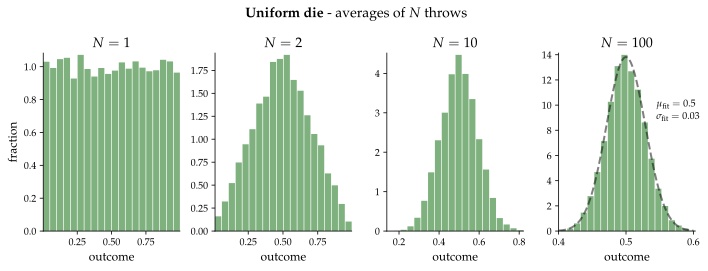

In [7]:
# uniform die
fig_u, ax_u = plt.subplots(1, 4, figsize=(10,3.8))
four_histograms(fig_u, ax_u, uniform_die, 'uniform', color='darkgreen')

# gaussian fit
fargs_u = norm.fit(uniform_die[:,3])
x = np.linspace(0.4, 0.6, 100)
ax_u[3].plot(x, norm.pdf(x, *fargs_u), '--', c='k', lw=2, alpha=0.5)
ax_u[3].text(1.1*text_x, text_y, f'$\mu_{{\\rm fit}} = {round(fargs_u[0], 2)}$', transform=ax_u[3].transAxes)
ax_u[3].text(1.1*text_x, 0.9*text_y, f'$\sigma_{{\\rm fit}} = {round(fargs_u[1], 2)}$', transform=ax_u[3].transAxes);

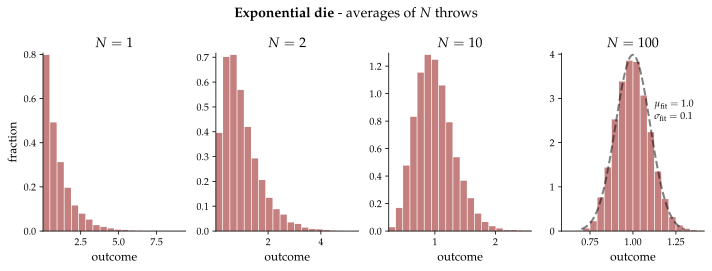

In [8]:
# exponential die
fig_e, ax_e =  plt.subplots(1, 4, figsize=(10,3.8))
four_histograms(fig_e, ax_e, exponential_die, 'exponential', color='darkred')

# gaussian fit
fargs_e = norm.fit(exponential_die[:,3])
x = np.linspace(0.7, 1.3, 100)
ax_e[3].plot(x, norm.pdf(x, *fargs_e), '--', c='k', lw=2, alpha=0.5)
ax_e[3].text(text_x, text_y, f'$\mu_{{\\rm fit}} = {round(fargs_e[0], 2)}$', transform=ax_e[3].transAxes)
ax_e[3].text(text_x, 0.9*text_y, f'$\sigma_{{\\rm fit}} = {round(fargs_e[1], 2)}$', transform=ax_e[3].transAxes);

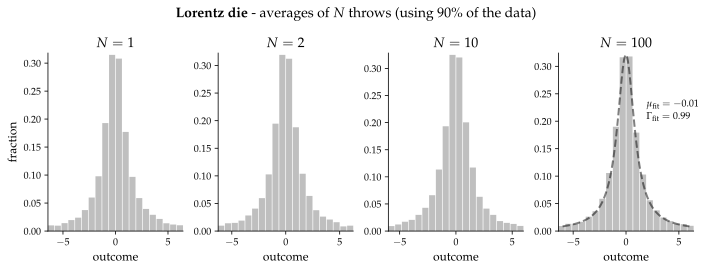

In [9]:
# Lorentz die
fig_l, ax_l =  plt.subplots(1, 4, figsize=(10,3.8))

# to deal with the infinite variance problem I decided to plot only a fixed percentage of the data
percentage = 90

# cut simmetrically with respect to the average (which is 0 in this case)
l_cut = np.array([ li[ np.abs(li) < np.percentile(np.abs(li), percentage) ] for li in lorentz_die.T ]).T

four_histograms(fig_l, ax_l, l_cut, 'lorentz', bins=20, color='grey')
new_title = fig_l._suptitle.get_text() + f' (using ${percentage}\%$ of the data)'
fig_l.suptitle(new_title);

# lorentzian fit
fargs_l = cauchy.fit(lorentz_die[:,3])
x = np.linspace(-6, 6, 100)
ax_l[3].plot(x, cauchy.pdf(x, *fargs_l), '--', c='k', lw=2, alpha=0.5)
ax_l[3].text(text_x, text_y, f'$\mu_{{\\rm fit}} = {round(fargs_l[0], 2)}$', transform=ax_l[3].transAxes)
ax_l[3].text(text_x, 0.9*text_y, f'$\Gamma_{{\\rm fit}} = {round(fargs_l[1], 2)}$', transform=ax_l[3].transAxes);

In [10]:
'''this code cell is a divertissement to make the previous plots interactive, and doesn't really add new 
information. If you're interesed in ``manually'' changing the parameters (not all parameters are customizable)
of the histograms you can do so by un-commenting the 3 code cells below.'''

def to_index(N):
    i = np.argwhere(sizes == N)
    if i.size > 0:
        return i[0,0]
    else:
        print(f'{N} is not a valid size. Available choices: {[ n for n in sizes ]}')
        print(f'Using {sizes[0]} instead.')
        return sizes[0]
    
def histo(N, data, name, color, bins=20):
    fig, ax = plt.subplots(figsize=(4,5))
    set_labels(ax, xlabel="outcome", ylabel='fraction')
    ax.hist(data, bins=bins, color=color, alpha=.5, rwidth=0.9, density=True)
    plural = 's'
    if N == 1:
        plural = ''
    fig.suptitle(f'\\textbf{{ {name.title()} die}} - averages of ${N}$ throw{plural}')
    
def uniform_histo(N, fit=False):
    i = to_index(N)
    histo(N, uniform_die[:,i], 'uniform', 'darkgreen')
    if fit:
        gauss_fit(uniform_die[:,i])
    
def exponential_histo(N, fit=False):
    i = to_index(N)
    histo(N, exponential_die[:,i], 'exponential', 'darkred')
    if fit:
        gauss_fit(exponential_die[:,i])
    
def lorentz_histo(N, percentage=90, bins=20, fit=False):
    i = to_index(N)
    l = lorentz_die[:,i]
    l_abs = np.abs(l)
    l = l[ l_abs < np.percentile(l_abs, percentage)]
    histo(N, l, 'lorentz', 'grey', bins=bins)
    x_min = np.min(l)
    x_max = np.max(l)
    if fit:
        lorentz_fit(lorentz_die[:,i], x_min, x_max)
    
def gauss_fit(data):
    fargs = norm.fit(data)
    x = np.linspace(fargs[0] - 3*fargs[1], fargs[0] + 3*fargs[1], 100)
    plt.plot(x, norm.pdf(x, *fargs), '--', c='k', lw=2, alpha=0.5)
    text_x = fargs[0] + 1.5*fargs[1]
    text_y = .7*np.max(norm.pdf(x, *fargs))
    plt.text(text_x, text_y, f'$\mu_{{\\rm fit}} = {fargs[0]:.2f}$', size=12)
    plt.text(text_x, 0.9*text_y, f'$\sigma_{{\\rm fit}} = {fargs[1]:.2f}$', size=12);
    
def lorentz_fit(data, x_min, x_max):
    fargs = cauchy.fit(data)
    x = np.linspace(x_min, x_max, 100)
    plt.plot(x, cauchy.pdf(x, *fargs_l), '--', c='k', lw=2, alpha=0.5)
    text_x = fargs[0] + 2*fargs[1]
    text_y = .7*np.max(cauchy.pdf(x, *fargs))
    plt.text(text_x, text_y, f'$\mu_{{\\rm fit}} = {fargs[0]:.2f}$', size=12)
    plt.text(text_x, 0.9*text_y, f'$\Gamma_{{\\rm fit}} = {fargs[1]:.2f}$', size=12);
    
from ipywidgets import SelectionSlider
N_u = SelectionSlider(options=[1,2,10,100], description='N')
N_e = SelectionSlider(options=[1,2,10,100], description='N') # duplicate for independent interaction
N_l = SelectionSlider(options=[1,2,10,100], description='N') # same

In [11]:
#interactive(uniform_histo, N=N_u)

In [12]:
#interactive(exponential_histo, N=N_e)

In [13]:
#interactive(lorentz_histo, N=N_l, percentage=(0,100), bins=(5,50,1))

## exercise 1.3
    
Buffon's experiment consists in the following scenario: a needle of length $L$ is thrown at random onto a horizontal plane ruled with straight lines a distance $d$ apart. The probability $P$ that the needle will intersect one of these lines is: $P = \frac{2L}{\pi d}$ (it must be $L < d$, but not $L\ll d$ otherwise $P\ll 1$). This could be used to evaluate $\pi$ from throws of the needle: if the needle is thrown down $N_{\text{thr}}$ times and is observed to land on a line $N_{\text{hits}}$ of those times, we can make an estimate of $\pi$ from

$$\pi = \frac{2L}{Pd} = \lim_{N_{\text{thr}} \to \infty}\frac{2LN_{\text{thr}}}{N_{\text{hits}}d}$$
    
<p class="assignement"> Plot the estimation of $\pi$ and its uncertainty (Standard Deviation of the mean) with a large number of throws $M$ as a function of the number of blocks, $N$.</p>

<p class="remark"> If possible, do not use $\pi$ to evaluate $\pi$ (I did not).</p>

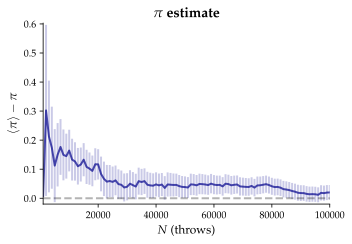

In [14]:
filename = results_directory + "pi_estimate.dat"
title = "$\pi$ estimate"
xlabel = "$N$ (throws)"
ylabel = "$\\langle\pi\\rangle-\pi$"
expected_y = np.pi

fig, ax = plt.subplots(figsize=(5,3.5))
set_labels(ax,  title, xlabel, ylabel)
estimation_plot(ax, filename, expected_y)